In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias, load_metrics
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"src\rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                target_name = "qmeas",
                color = "#E69F00",
                ls = "--",
                  ),
    "arimax": ModelHandler("ARIMAX",
                r"src\rst\ARIMAX",
                is_final_model = True,
                is_external_model = True,
                target_name = "qmeas",
                color = "#0072B2",
                ls = "--",
                  ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"src\rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"src\rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     "lstm": ModelHandler("LSTM",
                   r"src\rst\LSTM",
                   is_final_model = True,
                   color = "#CC79A7",
                   ls = "-",
                 ),
     }


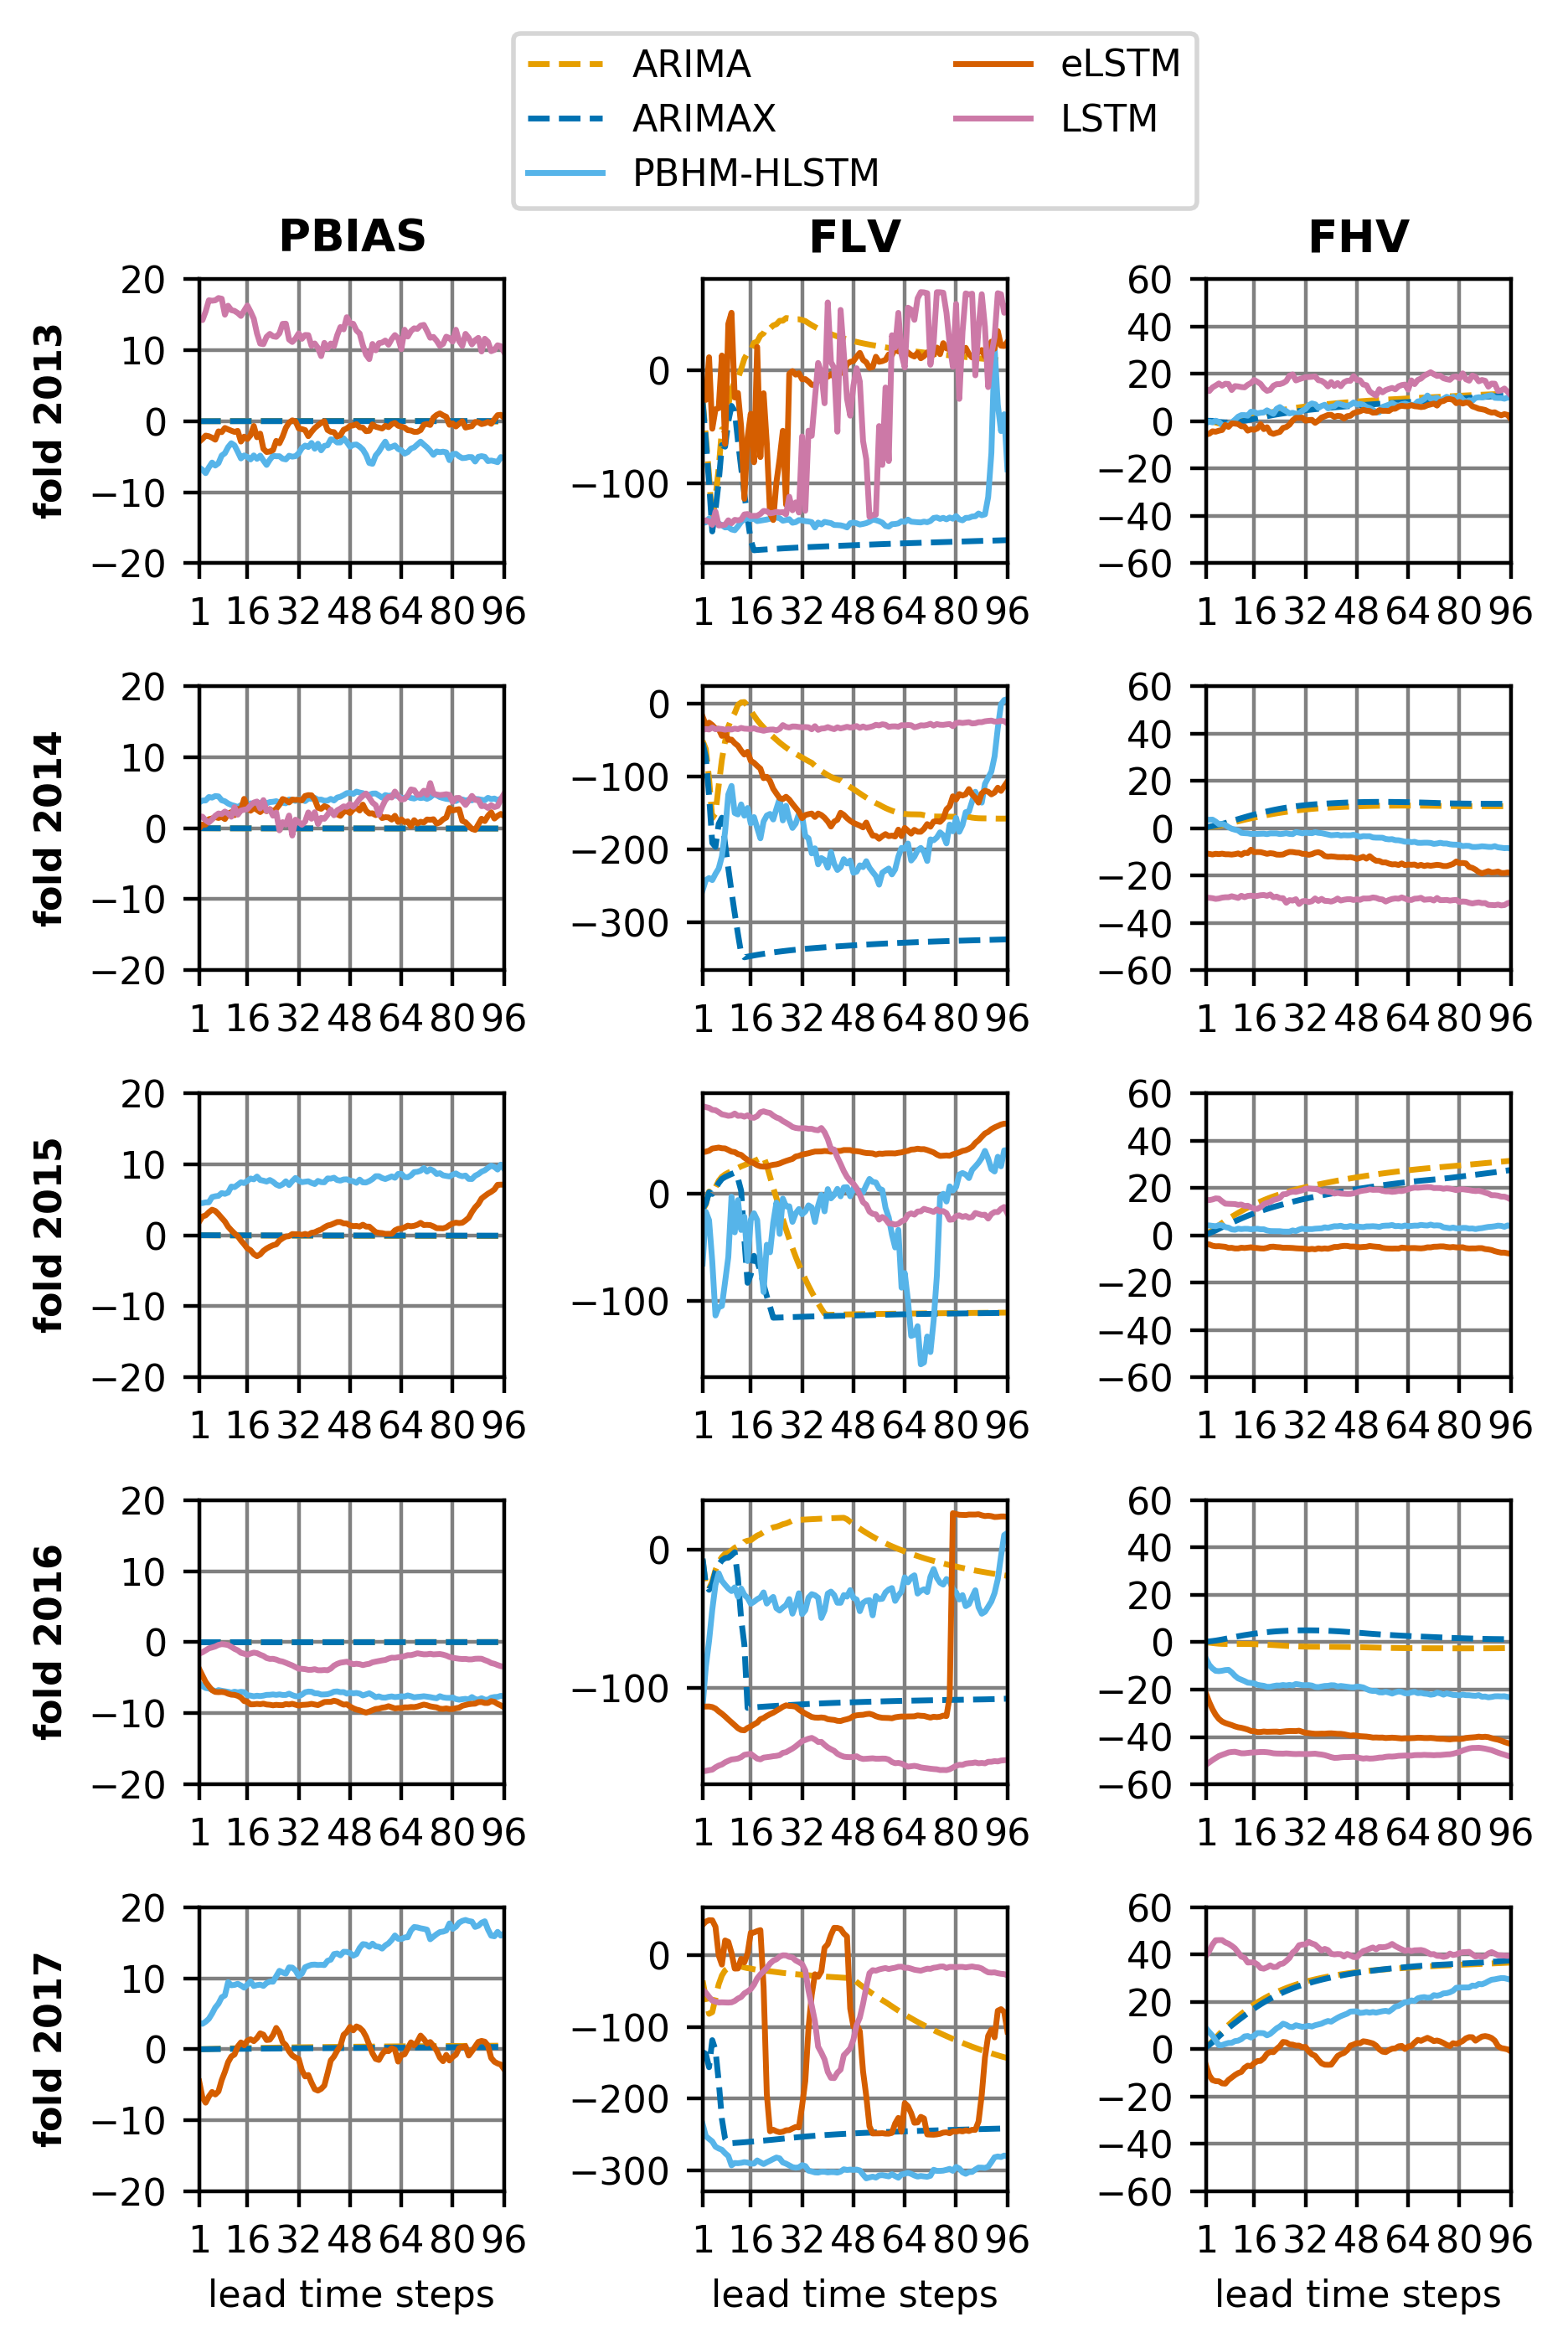

In [4]:
fig, axes = plt.subplots(5,3,figsize=(4.72,6.5), dpi=400)

metric_names = ["pbias", "flv", "fhv"]
metric_labels = ["PBIAS", "FLV", "FHV"]
ylims = [(0,1), (-2,1), (-20,10)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "bias_pass", "flv_pass", "fhv_pass",
                           "bias_min", "bias_avg", "bias_max", 
                           "flv_min", "flv_avg", "flv_max", 
                           "fhv_min", "fhv_avg", "fhv_max"])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    if models[key].name != "ARIMA":
        for j, met in enumerate(metric_names):
            metric  = metrics["test"][met]
            for i in range(5):
                df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
                df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                               np.mean(metric[i]), 
                                                                               np.max(metric[i])]
                df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
                
                xx = np.arange(1,np.array(metric[i]).shape[0]+1)
                axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1.25)
    else:          
        for j, met in enumerate(metric_names):
            metric  = metrics["test"][met]
            for i in range(5):
                df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
                df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                               np.mean(metric[i]), 
                                                                               np.max(metric[i])]
                df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
                xx = np.arange(1,np.array(metric[i]).shape[0]+1)
                axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label="ARIMA", lw=1.25)


for i in range(5):
    for j in range(3):
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"fold\ {2013 + i}"+r"}$")
 
        axes[i,j].set_xticks([1,16,32,48,64,80,96])
        
        if j == 1:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(100))
        elif j == 0:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].set_ylim((-20,20))
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(20))
            axes[i,j].set_ylim((-60,60))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')

fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(0.5, 1.25), 
                 loc='lower center', ncol=2, 
                 borderaxespad=0)


In [5]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'figX_leadtime_performance-bias.png'), bbox_inches="tight")

In [6]:
dft = df.drop(df.columns[2:14], axis=1)
arima   = dft.loc[0:4,:].values[:,2:]
hlstmpb = dft.loc[5:9,:].values[:,2:]
hlstm   = dft.loc[10:,:].values[:,2:]
dft

,name,year,pbias_min,pbias_avg,pbias_max,pbias_0,pbias_1,pbias_2,pbias_3,pbias_4,...,fhv_86,fhv_87,fhv_88,fhv_89,fhv_90,fhv_91,fhv_92,fhv_93,fhv_94,fhv_95
0,ARIMA,2013,-0.053995,0.020626,0.047042,0.000717,0.001975,0.003565,0.005309,0.007077,...,11.195563,11.253203,11.308862,11.363554,11.421309,11.479356,11.535954,11.592306,11.648290,11.704149
1,ARIMA,2014,-0.044379,-0.031338,-0.000910,-0.000910,-0.002223,-0.003711,-0.005376,-0.007095,...,9.316476,9.313267,9.313230,9.312671,9.311476,9.311841,9.311479,9.311532,9.312567,9.312186
2,ARIMA,2015,-0.104698,-0.069297,-0.001628,-0.001628,-0.004142,-0.007180,-0.010384,-0.013654,...,30.346835,30.473588,30.599170,30.724337,30.846944,30.969365,31.092807,31.216297,31.339370,31.462505
3,ARIMA,2016,0.000369,0.017186,0.028030,0.000369,0.000900,0.001494,0.002123,0.002765,...,-2.545705,-2.540123,-2.533076,-2.525592,-2.517252,-2.506837,-2.493692,-2.479801,-2.464582,-2.449052
4,ARIMA,2017,0.007793,0.326514,0.511570,0.007793,0.018960,0.031457,0.044700,0.058204,...,36.098919,36.155498,36.214828,36.274207,36.337769,36.396832,36.455596,36.520867,36.582915,36.647510
5,ARIMAX,2013,0.000224,0.013552,0.023260,0.000224,0.000617,0.001119,0.001678,0.002253,...,10.219218,10.303167,10.388688,10.473528,10.555425,10.642430,10.727842,10.815793,10.902976,10.990747
6,ARIMAX,2014,-0.039924,-0.024193,-0.000428,-0.000428,-0.001184,-0.002037,-0.002964,-0.003959,...,10.344249,10.336365,10.330072,10.323759,10.322927,10.324579,10.330462,10.337322,10.339033,10.342876
7,ARIMAX,2015,-0.061743,-0.034544,-0.000689,-0.000689,-0.001565,-0.002601,-0.003722,-0.004893,...,25.925278,26.100065,26.275045,26.449259,26.621247,26.814538,27.006641,27.200756,27.378806,27.571931
8,ARIMAX,2016,0.000143,0.010505,0.019201,0.000143,0.000381,0.000651,0.000940,0.001240,...,1.445573,1.413371,1.384672,1.362941,1.344568,1.331417,1.316864,1.309457,1.307445,1.302928
9,ARIMAX,2017,0.003196,0.183182,0.326225,0.003196,0.007827,0.013076,0.018695,0.024508,...,36.688327,36.768498,36.851395,36.940162,37.035196,37.136462,37.245781,37.351329,37.458009,37.558188
